In [1]:
!pip install panel --upgrade
!pip install catboost --upgrade
!pip install plotly --upgrade
!pip install bokeh --upgrade
!pip install scikit-learn --upgrade

# Телекоммуникации

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.

In [2]:
import pandas as pd
import panel as pn
import plotly.express as px
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, cv, Pool
from sklearn.dummy import DummyClassifier
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

import io
pn.extension()
pn.extension('plotly')

In [3]:
dt_load = '2020-02-01' # Дата выгрузки датасетов
r_s = 280823

In [4]:
ds = []
for file in ['contract_new.csv', 'internet_new.csv', 'personal_new.csv', 'phone_new.csv']:
    try:
        ds.append(pd.read_csv('./' + file))
    except FileNotFoundError:
        ds.append(pd.read_csv('/datasets/' + file))

## Предварительный анализ данных

In [5]:
def describe(df, fileshow_hist=True):
    buf = io.StringIO()
    df.info(buf=buf)
    s = buf.getvalue()
    lines = [line.split() for line in s.splitlines()[5:-2]]
    df_info = pd.DataFrame(lines).set_index(0)
    df_info['Non-Null Count'] = df_info[2] + ' ' + df_info[3]
    df_info.drop(columns=[2,3], inplace=True)
    df_info.columns = ['Column', 'Dtype', 'Non-Null Count']
    df_info_header = "\n".join(s.splitlines(keepends=True)[:3]).replace("#", 'Номер')
    df_info_footer = "\n".join(s.splitlines(keepends=True)[-1:-3:-1])
    return (pn.Column('Общая информация', df_info_header, pn.pane.DataFrame(df_info)), df_info_footer,
            pn.Column('Описание', pn.pane.DataFrame(df.describe(include='all'))),
            pn.Column('Первые 15 записей', pn.pane.DataFrame(df.head(15))),
            pn.Column('Количество дубликатов ', df.duplicated().sum())
        )

In [6]:
describe_files = pn.Tabs(dynamic=True)
for title, df in [('Информация о договоре', ds[0]), 
            ('Информация об интернет-услугах', ds[1]),
            ('Персональные данные клиента', ds[2]),
            ('Информация об услугах телефонии', ds[3])]:
    try:
        describe_files.append((title, pn.Column(*describe(df))))
    except FileNotFoundError:
        describe_files.append((title, pn.Column(*describe(df))))

In [7]:
describe_files

### Промежуточные выводы

Датасеты имеют единственное общее поле - **customerID**, по которому их следует объединить, чтобы сформировать общую выборку.

#### Информация о договоре

Дтасет не содержит пропусков и явных дубликатов.

Дата и время:
- EndDate;
- BeginDate.

Категориальные признаки:
- Type;
- PaymentMethod.

Числовые признаки:
- MonthlyCharges;
- PaperlessBilling;
- TotalCharges.

#### Информация об интернет-услугах

Дтасет не содержит пропусков и явных дубликатов.

Категориальные признаки:
- InternetService;
-  OnlineSecurity;
- OnlineBackup;
- DeviceProtection;
- TechSupport;
- StreamingTV;
- StreamingMovies;

#### Персональные данные клиента

Дтасет не содержит пропусков и явных дубликатов.

Категориальные признаки:
- gender;
- SeniorCitizen;
- Partner;
- Dependents.

#### Информация об услугах телефонии

Дтасет не содержит пропусков и явных дубликатов.

Категориальные признаки: MultipleLines.

## План решения:

- Предобработка:
    - Объединить таблицы по ключу - customerID (OUTER JOIN);
    - Привести колонки к подходящим типам данных;
    - Удалить записи младше 1 февраля 2020 года;
    - Добавить признак - delta_month, хранящую количество месяцев, в течении которых клиент пользуется услугами;
    - Отбросить неинформативные признаки;
    - Если возможно, заменить пропуск нулём или новым значением признака;
    - Отбросить строки с остальными пропусками;
    - Удалить дубликаты в итоговой таблице, если они присутствуют.
- Исследовательский анализ:
    - Провести анализ зависимости целевого признака от остальных;
    - Провести анализ корреляции целевого признака и мультиколлинеарности остальных признаков.
- Обучение моделей:
    - Разделить выборку на тестовую и обучающую 1:3;
    - Закодировать категориальные признаки, нормализировать по выборкам;
    - Обучить модели градиентного бустинга и случайного леса, решающие задачу бинарной классификации;
    - Выбрать лучшую модель на кросс-валидации;
    - Проверить выбранную модель на тестовой выборке;
    - Проверить модели на адекватность.

## Цель проекта

Разработать модель машинного обучения для прогнозирования оттока клиентов, которая обеспечивает метрику ROC-AUC > 0.85.

## Предобработка

### Объединение таблиц

Перед объединением по OUTER JOIN необходимо сделать поле **customerID** первичным ключом во всех таблицах.

In [8]:
for df in ds:
    df.set_index('customerID', inplace=True)

Объединение по первичному ключу.

In [9]:
gl_df = pd.concat(ds, axis=1)

### Обработка пропусков

Строковые значения 'None', 'null', 'NULL', 'none', а также пробельные символы переводятся в тип np.nan.

In [10]:
gl_df.replace(['None', 'null', 'NULL', 'none', ' '], np.nan, inplace=True)

Отношение пропусков к размеру выборки по колонкам.

In [11]:
round(gl_df.isna().sum() / len(gl_df) * 100, 3).astype('str') + ' %'

По большей части пропуски обусловленны отсутствием записей в таблицах Информация об интернет-услугах и Информация об услугах телефонии. Т.к. размер выборки невелик и нужно стараться сохранить данные, можно предположить, что их там нет т.к. пользователи не имеют данных услуг.

Пропуски в колонке с категориальным признаком **InternetService** заменяются на тип 'None'. 

В колонках с бинарными признаками **OnlineSecurity**, **OnlineBackup**, **DeviceProtection**, **TechSupport**, **StreamingTV**, **StreamingMovies** пропусков более 21% от общей выборки. Значения в этих колонках заменяются на 0. В бинарной колонке **MultipleLines** около 10% пропусков значения в ней заменяются на 0.

Предварительно, значения в бинарных признаках приводятся к числовому типу данных.

Пропуски в колонке **TotalCharges** неявные - пробельный символ.

In [12]:
gl_df[gl_df['TotalCharges'].isna()]

Все даты записей с пустым **TotalCharges** совпадают с датой выгрузки, можно предположить, что списание средств ещё не произошло и заменить пропуски на месячные расходы.

In [13]:
idx = gl_df['TotalCharges'].isna()
gl_df.loc[idx, 'TotalCharges'] = gl_df.loc[idx, 'MonthlyCharges']

In [14]:
gl_df['InternetService'] = gl_df['InternetService'].fillna('No')
gl_df.fillna('No', inplace=True)

### Формирование целевого признака

Бинарный целевой признак - ушёл ли клиент, формируется как 0, если значение в поле **EndDate** - 'No', иначе 1.

In [15]:
gl_df['target'] = gl_df['EndDate'].apply(lambda x: 0 if x == 'No' else 1)

### Приведение типов данных

Перед приведением поля **EndDate** значения 'No' в нём заменяются на дату выгрузки датасета.

Поля **BeginDate** приводится к типу даты и времени.

Поля **MonthlyCharges**, **PaperlessBilling**, **TotalCharges** приводятся к числовому типу.

In [16]:
gl_df['BeginDate'] = pd.to_datetime(gl_df['BeginDate'])
gl_df.loc[gl_df['EndDate'] == 'No', 'EndDate'] = dt_load
gl_df['EndDate'] = pd.to_datetime(gl_df['EndDate'])
gl_df['BeginDate'] = pd.to_datetime(gl_df['BeginDate'])
gl_df['MonthlyCharges'] = gl_df['MonthlyCharges'].astype('float')
gl_df['TotalCharges'] = gl_df['TotalCharges'].astype('float')
gl_df['SeniorCitizen'] = gl_df['SeniorCitizen'].apply(lambda x: "No" if x == 0 else 'Yes')
gl_df['SeniorCitizen'] = gl_df['SeniorCitizen'].apply(lambda x: "No" if x == 0 else 'Yes')

### Добавление новых признаков, удаление неинформативных и дубликатов

В выборку добавляется признак - количество дней, которые клиент пользуется (пользовался) услугами и признак, характеризующий значение месячных трат, привышающих медианную.

Поля **EndDate** и **BeginDate** отбрасываются.

In [17]:
gl_df['monthly_big'] = gl_df['MonthlyCharges'].apply(lambda x: 'No' if x < gl_df['MonthlyCharges'].median() else 'Yes')

In [18]:
gl_df['total_days'] = (gl_df['EndDate'] - gl_df['BeginDate']).dt.days
gl_df.drop(columns = ["EndDate", "BeginDate"], inplace=True)

Удаление дубликатов

In [19]:
gl_df.drop_duplicates(inplace=True)

In [20]:
pn.Column("Итоговая выборка", *describe(gl_df))

## Исследовательский анализ

### Корреляция целевого признака

In [21]:
fig = px.imshow(gl_df.corr(), labels=dict(color="Корреляция"), width=600, height=600)
fig.show()

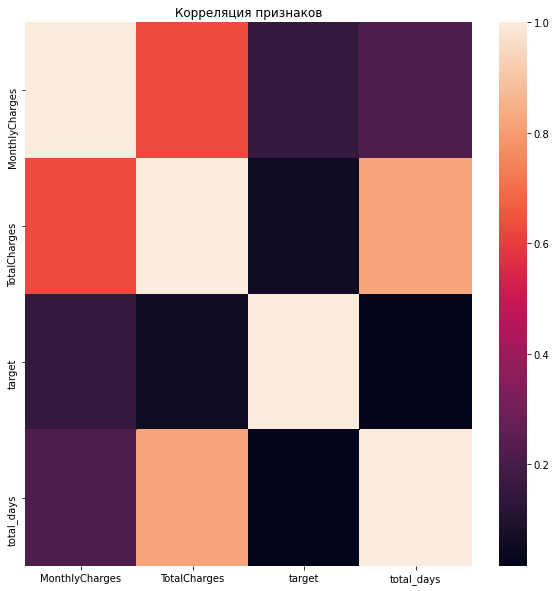

In [22]:
plt.subplots(figsize=(10, 10), )
ax = plt.axes()
sns.heatmap(gl_df.corr(), ax=ax)
ax.set_title('Корреляция признаков');

Целевой признак слабо коррелирует с признаком MonthlyCharges.

### Гистограммы признаков

In [23]:
for col in gl_df.columns:
    fig = px.histogram(gl_df, x=col, height=300)
    fig.show()

### Зависимость целевого признака от категориальных признаков

In [24]:
fig = px.histogram(gl_df, x="target", y=["Type", "PaymentMethod", 'InternetService', 'gender'],barmode='group', height=400, histfunc='avg')
fig.show()

Положительное значение целевого признака пробладает в группах: автопереводы, оптоволокнонное подключение, годовая и двухгодовые тип подписки.

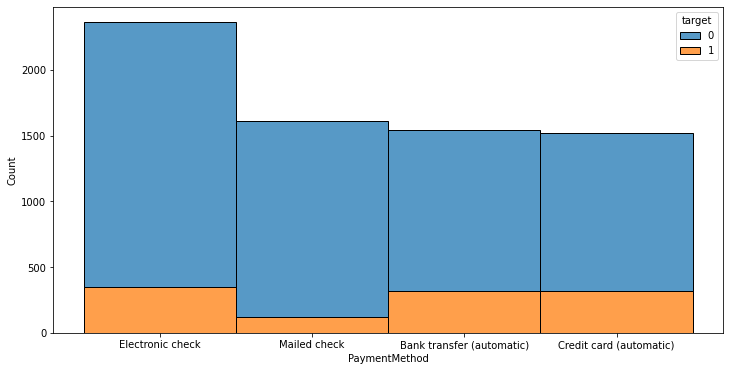

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(gl_df, x = 'PaymentMethod', hue = 'target', multiple = 'stack', stat='count');

Реже уходят клиенты, которые пользуются методом оплаты Mailed check.

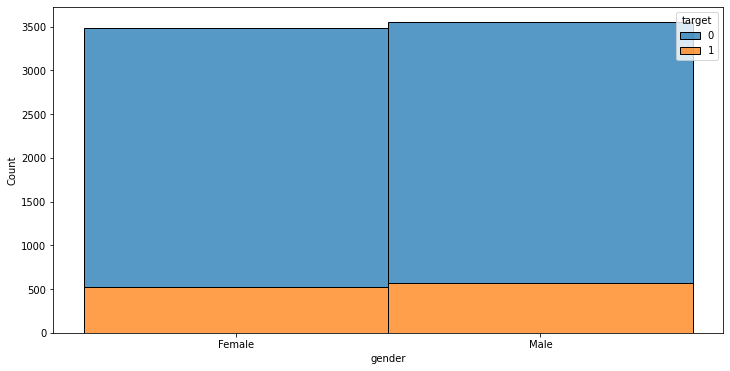

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(gl_df, x = 'gender', hue = 'target', multiple = 'stack');

Пол не влияет на вероятность ухода клиента.

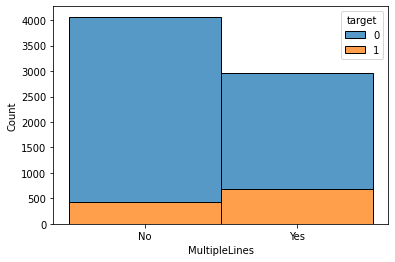

In [27]:
sns.histplot(gl_df, x = 'MultipleLines', hue = 'target', multiple = 'stack');

Чаще уходят клиенты, которые пользуются услугой MultipleLines.

### Мультиколлинеарность признаков

Признаки, связанные с подключенными интернет-услугами коррелируют между собой.

Признак TotalCharge сильно коррелирует с созданным признаком month_total и MonthlyCharges.

### Дисбаланс целевого признака

In [28]:
fig = px.histogram(gl_df, x="target", width=500)
fig.show()

Целевой признак распределён неравномерно, в выборке преобладают клиенты с  действующим договором.

## Обучение моделей

### Разбиение на выборки

In [29]:
X = gl_df.drop(columns=['target'])
y = gl_df['target']
cat_features = list(set(X.columns.tolist()) - set(['total_days', 'TotalCharges', 'MonthlyCharges']))
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = r_s, test_size=0.25, stratify=y)

### One hot encoding

In [30]:
transformer = make_column_transformer(
    (StandardScaler(), ['total_days', 'TotalCharges', 'MonthlyCharges']),
    (OneHotEncoder(drop='first'), cat_features),
    remainder='passthrough',
    verbose_feature_names_out=False)

transformed = transformer.fit_transform(X_train, y_train)
X_train_enc = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names_out()
)
transformed = transformer.transform(X_test)
X_test_enc = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names_out()
)

In [31]:
X_train_enc.head()

### CatBoostClassifier

#### Значимость признаков

In [32]:
cat = CatBoostClassifier(iterations=4000, random_state=r_s, verbose=False, learning_rate=0.003, eval_metric = 'AUC', loss_function='Logloss',
                         depth = 4, auto_class_weights='Balanced')
cat.fit(X_train_enc, y_train);

In [33]:
fig = px.bar(x=list(X_train_enc.columns), y=cat.get_feature_importance(), barmode='group', height=400)
fig.show()

Числовые признаки имеют большее влияние на обучение модели градиентного бустинга.

In [34]:
cat = CatBoostClassifier(random_state=r_s, verbose=False, eval_metric='AUC', loss_function = 'CrossEntropy')

#### Кроссвалидация

In [35]:
btn_cat_valid = pn.widgets.Button(name='Запустить кроссвалидацию')
def cat_valid(e):
    if not e:
        return
    try:
        btn_cat_valid.loading = True
        cat_grid_space={
            'depth':[2,3,4],
            'iterations': [500, 1000],
            'learning_rate': [0.01, 0.05]
        }
        grid = GridSearchCV(cat,param_grid=cat_grid_space,cv=4,scoring='roc_auc')
        model_grid = grid.fit(X_train_enc, y_train)
        return f'Лучшие параметры: {model_grid.best_params_}', f'Лучший ROC AUC: {model_grid.best_score_}'
    finally:
        btn_cat_valid.loading = False

In [36]:
pn.Column(btn_cat_valid, pn.bind(cat_valid, btn_cat_valid))

#### Кроссвалидация с визуализацией

In [37]:
X_train.info()

In [38]:
params = {
    'loss_function': 'CrossEntropy',
    'iterations': 1000,
    'custom_loss': 'AUC',
    'random_state': r_s,
    "learning_rate": 0.01,
    'depth': 4,
    'eval_metric': "AUC"
}

cv_data = cv(
    params=params,
    pool=Pool(X_train_enc, label=y_train),
    fold_count=4,
    partition_random_seed=r_s,
    verbose=False,
    shuffle=True,
    plot=True
)

### Случайный лес

#### Значимость признаков

In [39]:
forest = RandomForestClassifier(random_state=r_s, n_estimators=200, max_depth=8, class_weight='balanced')
forest = forest.fit(X_train_enc, y_train)

In [40]:
fig = px.bar(x=list(X_train_enc.columns), y=forest.feature_importances_, barmode='group', height=400)
fig.show()

Числовые признаки имеют большее влияние на обучение модели случайного леса.

#### Кроссвалидация

In [41]:
forest = RandomForestClassifier(class_weight='balanced', random_state=r_s, n_estimators=200, max_depth=10, bootstrap=True)

In [42]:
btn_forest_valid = pn.widgets.Button(name='Запустить кроссвалидацию')
def forest_valid(e):
    if not e:
        return
    try:
        btn_forest_valid.loading = True
        forest_grid_space={
            'max_depth':[8,10,12],
            'n_estimators': [100, 200, 300]
        }
        grid = GridSearchCV(forest,param_grid=forest_grid_space,cv=4,scoring='roc_auc')
        model_grid = grid.fit(X_train_enc, y_train)
        return pn.Column(f'Лучшие параметры: {model_grid.best_params_}', f'Лучший ROC AUC: {model_grid.best_score_}')
    finally:
        btn_forest_valid.loading = False

In [43]:
pn.Column(btn_forest_valid, pn.bind(forest_valid, btn_forest_valid))

### Выбор лучшей модели

Производится на основании метрики ROC-AUC при кросс-валидации: модель градиентного бустинга (ROC AUC 0.85),

случайный лес (ROC AUC 0.82).

### Интерактивный прогон лучшей модели на тестовой выборке и проверка на адекватность

In [44]:
iter = pn.widgets.FloatInput(start=1, end=20000, name="Итерации", value=1000, step=1)
depth = pn.widgets.IntSlider(start=1, end=10, value=4, name="Глубина дерева")
loss_function = pn.widgets.Select(options=['Logloss', 'CrossEntropy'], name="Функция потерь")
l_r = pn.widgets.FloatInput(start=0.00001, end=1, name="Learning rate", value=0.10001, step=0.01)

def pipeline(iter, depth, loss_function, l_r):
    fig = px.area(
        title=f'Обучающая выборка CatBoostClassifier',
        labels=dict(x='FPR', y='TPR'),
    )
    model = CatBoostClassifier(iterations=iter, random_state=r_s, verbose=False, learning_rate=l_r, eval_metric = 'AUC', loss_function=loss_function,
                         depth = depth, auto_class_weights='Balanced')
    dummy_clf = DummyClassifier(strategy="most_frequent")
    dummy_clf.fit(X_train_enc, y_train)
    pred_train = dummy_clf.predict(X_test_enc)
    proba_train = dummy_clf.predict_proba(X_test_enc)
    proba_one_train = proba_train[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, proba_one_train)
    dummy_acc = round(accuracy_score(y_test, pred_train), 2)
    fig.add_trace(go.Scatter(x=fpr, y=tpr, fill='tonexty', name='Dummy'))
    
    model.fit(X_train_enc, y_train)
    pred_train = model.predict(X_test_enc)
    proba_train = model.predict_proba(X_test_enc)
    proba_one_train = proba_train[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, proba_one_train)
    model_auc = round(auc(fpr, tpr), 2)
    model_acc = round(accuracy_score(y_test, pred_train), 2)

    fig.add_trace(go.Scatter(x=fpr, y=tpr, fill='tozeroy', name='Cat'))
    fig.add_shape(
        type='line',
        line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1
    )

    return pn.Column(
            pn.indicators.Number(
            name=f"AUC ROC",
            value=model_auc,
            format="{value}",
            colors=[(0.83, "red"), (0.85, "orange"), (1, "green")],
            align='center'
        ), 
        pn.Row(f'Accuracy модели: {model_acc}', f'Dummy accuracy: {dummy_acc}'),
        fig)

pn.Row(
    pn.Column(
        pn.Column(iter, depth, loss_function, l_r),
        pn.bind(pipeline, iter, depth, loss_function, l_r),
    ),
).servable()

Проверка на адекватность пройдена

## Итоги и выводы




- Предобработка:
    - Таблицы объединены по ключу - customerID (OUTER JOIN);
    - Колонки приведены к подходящим типам данных;
    - Записи младше 1 февраля 2020 года удалены;
    - Добавлен признак - delta_day, хранящий количество дней, в течении которых клиент пользуется услугами;
    - Отброшены неинформативные признаки CustomerID, BeginDate, EndDate;
    - Устранены пропуски;
    - Удалены дубликаты.
- Исследовательский анализ:
    - Проведен анализ зависимости целевого признака от остальных;
    - Проведен анализ корреляции целевого признака и мультиколлинеарности остальных признаков.
- Обучение моделей:
    - Категориальные признаки закодированы, числовые нормализированы по выборкам;
    - Обучены модели градиентного бустинга и случайного леса, решающие задачу бинарной классификации;
    - Выбрана лучшая модель на кросс-валидации - модель CatBoost;
    - Модель проверена на тестовой выборке: AUC = 0.91, accuracy=0.89;
    - Модель прошла проверку на адекватность.

## Отчёт по решению

### Предобработка:

- Объединение таблицы по ключу - customerID (OUTER JOIN);
- Замена пробельных символов на NaN;
- Заполнение всех пропусков значением 'No';
- Формирование целевого признака как 0, если значение в колонке EndDate не "No", иначе 1;
- Замена значений 'No' в колонке EndDate датой выгрузки датасетов;
- Приведение полей MonthlyCharges и TotalCharges к числовому типу данных;
- Замена значений 0 и 1 в колонке SeniorCitizen на "No" и "Yes" соответственно;
- Формирование нового признака monthly_big, фиксирующего превышение значения колонки MontlyCharges своего медианного значения;
- Формирование нового признака total_days, содержащего число дней, в течении которых клиент пользуется услугами. Рассчитывается как разница в днях между колонками EndDate и BeginDate;
- Удаление колонок EndDate и BeginDate;
- Удаление явных дубликатов.
Признаки для обучения:
- total_days;
- TotalCharges;
- MonthlyCharges;
- OnlineBackup;
- StreamingMovies;
- DeviceProtection;
- StreamingTV;
- PaperlessBilling;
- gender;
- monthly_big;
- Partner;
- Dependents;
- Type;
- PaymentMethod;
- TechSupport;
- InternetService.

### Обучение модели:

- Итоговый датасет разбивается на обучающую и тестовую выборку в соотношении 3:1 с сохранением распределения целевого признака.
- Категориальные признаки кодируются методом OneHotEncoding;
- Числовые признаки нормализуются методом StandardScaler;
- Итоговая модель выбирается по метрике ROC AUC при кроссвалидации.

### Итоговая модель: CatBoostClassifier

Гиперпараметры модели: глубина дерева - 4, количество итераций - 1000, learning_rate - 0.010001.

### Отличие от исходного плана работ

Формируется признак количества дней, а не месяцев, в течении которых клиент пользуется услугами.

### Ключевые этапы

К ключевым этапом стоит отнести предобработку данных и обучение моделей.

Размер тестовой выборки: 1759 записей.

Random state: 280823